In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [178]:
import prototype_GRB_population as pt
import numpy as np
import matplotlib.pyplot as plt
import f90_functions as f90f
from pathlib import Path

[INFO] dir paths : 
    'root'    : /Users/palmerio/Science_projects/GRB_population_model
    'obs'     : /Users/palmerio/Science_projects/GRB_population_model/observational_constraints
    'init'    : /Users/palmerio/Science_projects/GRB_population_model/init
    'output'  : /Users/palmerio/Science_projects/GRB_population_model/model_outputs
    'data'    : /Users/palmerio/Science_projects/GRB_population_model/data
    'cosmo'   : /Users/palmerio/Science_projects/GRB_population_model/data/cosmology
    'ECLAIRs' : /Users/palmerio/Science_projects/GRB_population_model/data/ECLAIRs
[INFO] file paths : 
    'config'  : /Users/palmerio/Science_projects/GRB_population_model/init/config.yml
    'param'   : /Users/palmerio/Science_projects/GRB_population_model/init/parameters.yml
    'instrum' : /Users/palmerio/Science_projects/GRB_population_model/init/instruments.yml
    'sample'  : /Users/palmerio/Science_projects/GRB_population_model/init/samples.yml
[INFO] Input configuration:
Nb_GRBs: 

In [64]:
import matplotlib.colors as colors
from matplotlib import cm
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

aaa = MidpointNormalize(vmin=0.017402263733780076, vmax=1.409916083091681, midpoint=0.7629736339461802)
asa = aaa(1.4)
cm.Spectral_r(asa)

(0.6280661284121491, 0.013302575932333721, 0.26082276047673975, 1.0)

pflx min, med, max : 0.017402263733780076 0.7629736339461802 1.4099161816296266


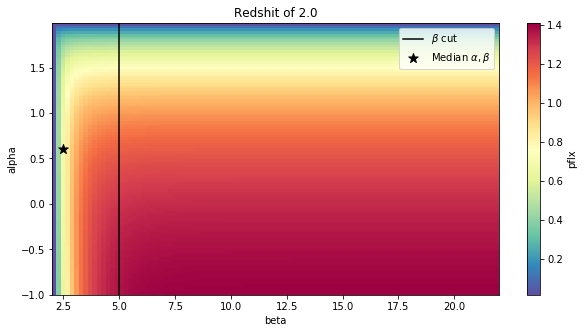

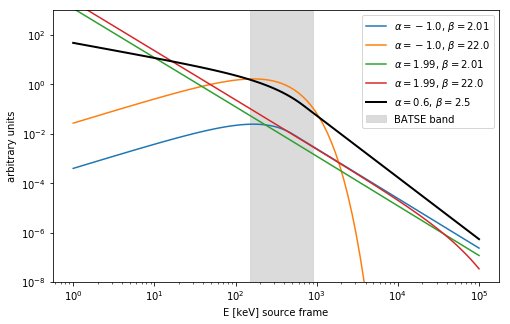

In [83]:
L = 1.0e52
z = 2.0
D_L = pt.Lum_dist(z, pt.cosmo)
Ep = 500.
Emin = 50.
Emax = 300.

Na, Nb = (100, 100)
alphas = np.linspace(-1., 1.99, Na)
betas = np.linspace(2.01, 22., Nb)

pflx = np.zeros((Nb,Na))
for i,alpha in enumerate(alphas):
    for j,beta in enumerate(betas):
        ktild = f90f.f90f.calc_ktild(alpha*np.ones(1), beta*np.ones(1))[0]
        pflx[j,i] = pt.Nb_ph(L, z, Ep, D_L, alpha, beta, ktild, Emin, Emax)
        #print(alpha, beta, ktild, pflx[j,i])

ktild_med = f90f.f90f.calc_ktild(0.6*np.ones(1), 2.5*np.ones(1))[0]
pflx_med = pt.Nb_ph(L, z, Ep, D_L, 0.6, 2.5, ktild_med, Emin, Emax)
print('pflx min, med, max :', pflx.min(), pflx_med, pflx.max())
pflx = np.flip(pflx,axis=1)
fig, ax = plt.subplots(figsize=(10,5))
mapp = ax.imshow(pflx.T, extent=(betas.min(), betas.max(), alphas.min(), alphas.max()),
            interpolation='nearest', aspect='auto', cmap='Spectral_r',
            norm=MidpointNormalize(vmin=pflx.min(), vmax=pflx.max(), midpoint=pflx_med))
ax.set_xlabel('beta')
ax.set_ylabel('alpha')
ax.scatter(2.5, 0.6, marker='*', color='k', s=100, label=r'Median $\alpha,\beta$')
ax.axvline(5, color='k', label=r'$\beta$ cut')
fig.colorbar(mapp, label='pflx')
ax.legend()
plt.title('Redshit of {}'.format(z))

fig, ax = plt.subplots(figsize=(8,5))
Esource = np.logspace(0,5, 100)
ktild00 = f90f.f90f.calc_ktild(alphas[0]*np.ones(1), betas[0]*np.ones(1))[0]
Band00 = pt.Btild(Esource/Ep, ktild00, alphas[0], betas[0])
ax.plot(Esource, Band00, label=r'$\alpha={},\,\beta={}$'.format(alphas[0],betas[0]))
ktild01 = f90f.f90f.calc_ktild(alphas[0]*np.ones(1), betas[-1]*np.ones(1))[0]
Band01 = pt.Btild(Esource/Ep, ktild01, alphas[0], betas[-1])
ax.plot(Esource, Band01, label=r'$\alpha={},\,\beta={}$'.format(alphas[0],betas[-1]))
ktild10 = f90f.f90f.calc_ktild(alphas[-1]*np.ones(1), betas[0]*np.ones(1))[0]
Band10 = pt.Btild(Esource/Ep, ktild10, alphas[-1], betas[0])
ax.plot(Esource, Band10, label=r'$\alpha={},\,\beta={}$'.format(alphas[-1],betas[0]))
ktild11 = f90f.f90f.calc_ktild(alphas[-1]*np.ones(1), betas[-1]*np.ones(1))[0]
Band11 = pt.Btild(Esource/Ep, ktild11, alphas[-1], betas[-1])
ax.plot(Esource, Band11, label=r'$\alpha={},\,\beta={}$'.format(alphas[-1],betas[-1]))
Band_med = pt.Btild(Esource/Ep, ktild_med, 0.6, 2.5)
ax.plot(Esource, Band_med, label=r'$\alpha={},\,\beta={}$'.format(0.6,2.5), color='k', lw=2)
ax.axvspan(Emin*(1+z), Emax*(1+z), alpha=0.8, color='lightgrey', label='BATSE band')
ax.legend()
ax.set_ylim(1e-8,1e3)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('E [keV] source frame')
ax.set_ylabel('arbitrary units')

plt.show()

pflx min, med, max : 1.7185308761725533 104.9604360971333 172.93951388439282


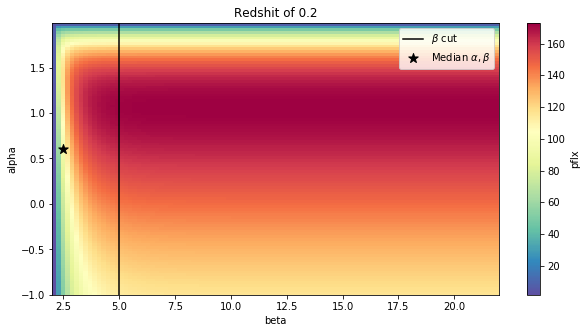

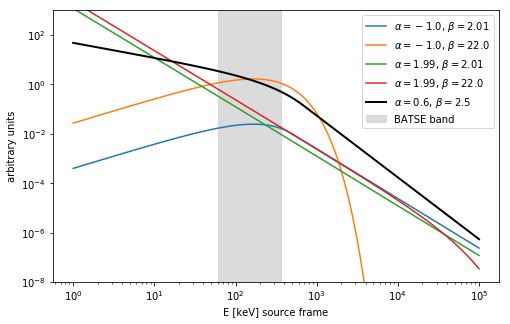

In [84]:
L = 1.0e52
z = 0.2
D_L = pt.Lum_dist(z, pt.cosmo)
Ep = 500.
Emin = 50.
Emax = 300.

Na, Nb = (100, 100)
alphas = np.linspace(-1., 1.99, Na)
betas = np.linspace(2.01, 22., Nb)

pflx = np.zeros((Nb,Na))
for i,alpha in enumerate(alphas):
    for j,beta in enumerate(betas):
        ktild = f90f.f90f.calc_ktild(alpha*np.ones(1), beta*np.ones(1))[0]
        pflx[j,i] = pt.Nb_ph(L, z, Ep, D_L, alpha, beta, ktild, Emin, Emax)
        #print(alpha, beta, ktild, pflx[j,i])

ktild_med = f90f.f90f.calc_ktild(0.6*np.ones(1), 2.5*np.ones(1))[0]
pflx_med = pt.Nb_ph(L, z, Ep, D_L, 0.6, 2.5, ktild_med, Emin, Emax)
print('pflx min, med, max :', pflx.min(), pflx_med, pflx.max())
pflx = np.flip(pflx,axis=1)
fig, ax = plt.subplots(figsize=(10,5))
mapp = ax.imshow(pflx.T, extent=(betas.min(), betas.max(), alphas.min(), alphas.max()),
            interpolation='nearest', aspect='auto', cmap='Spectral_r',
            norm=MidpointNormalize(vmin=pflx.min(), vmax=pflx.max(), midpoint=pflx_med))
ax.set_xlabel('beta')
ax.set_ylabel('alpha')
ax.scatter(2.5, 0.6, marker='*', color='k', s=100, label=r'Median $\alpha,\beta$')
ax.axvline(5, color='k', label=r'$\beta$ cut')
fig.colorbar(mapp, label='pflx')
ax.legend()
plt.title('Redshit of {}'.format(z))

fig, ax = plt.subplots(figsize=(8,5))
Esource = np.logspace(0,5, 100)
ktild00 = f90f.f90f.calc_ktild(alphas[0]*np.ones(1), betas[0]*np.ones(1))[0]
Band00 = pt.Btild(Esource/Ep, ktild00, alphas[0], betas[0])
ax.plot(Esource, Band00, label=r'$\alpha={},\,\beta={}$'.format(alphas[0],betas[0]))
ktild01 = f90f.f90f.calc_ktild(alphas[0]*np.ones(1), betas[-1]*np.ones(1))[0]
Band01 = pt.Btild(Esource/Ep, ktild01, alphas[0], betas[-1])
ax.plot(Esource, Band01, label=r'$\alpha={},\,\beta={}$'.format(alphas[0],betas[-1]))
ktild10 = f90f.f90f.calc_ktild(alphas[-1]*np.ones(1), betas[0]*np.ones(1))[0]
Band10 = pt.Btild(Esource/Ep, ktild10, alphas[-1], betas[0])
ax.plot(Esource, Band10, label=r'$\alpha={},\,\beta={}$'.format(alphas[-1],betas[0]))
ktild11 = f90f.f90f.calc_ktild(alphas[-1]*np.ones(1), betas[-1]*np.ones(1))[0]
Band11 = pt.Btild(Esource/Ep, ktild11, alphas[-1], betas[-1])
ax.plot(Esource, Band11, label=r'$\alpha={},\,\beta={}$'.format(alphas[-1],betas[-1]))
Band_med = pt.Btild(Esource/Ep, ktild_med, 0.6, 2.5)
ax.plot(Esource, Band_med, label=r'$\alpha={},\,\beta={}$'.format(0.6,2.5), color='k', lw=2)
ax.axvspan(Emin*(1+z), Emax*(1+z), alpha=0.8, color='lightgrey', label='BATSE band')
ax.legend()
ax.set_ylim(1e-8,1e3)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('E [keV] source frame')
ax.set_ylabel('arbitrary units')

plt.show()

pflx min, med, max : 0.0012393829007736128 0.06221465401925049 0.11958340868647278


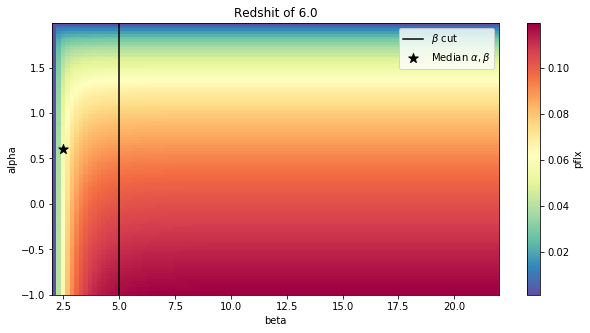

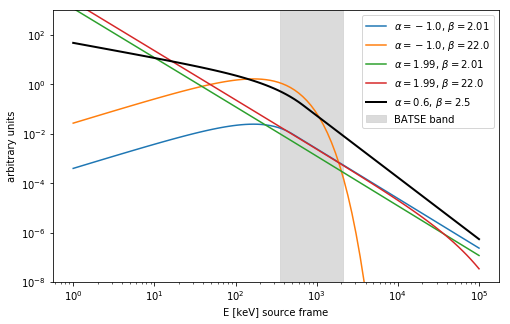

In [85]:
L = 1.0e52
z = 6.0
D_L = pt.Lum_dist(z, pt.cosmo)
Ep = 500.
Emin = 50.
Emax = 300.

Na, Nb = (100, 100)
alphas = np.linspace(-1., 1.99, Na)
betas = np.linspace(2.01, 22., Nb)

pflx = np.zeros((Nb,Na))
for i,alpha in enumerate(alphas):
    for j,beta in enumerate(betas):
        ktild = f90f.f90f.calc_ktild(alpha*np.ones(1), beta*np.ones(1))[0]
        pflx[j,i] = pt.Nb_ph(L, z, Ep, D_L, alpha, beta, ktild, Emin, Emax)
        #print(alpha, beta, ktild, pflx[j,i])

ktild_med = f90f.f90f.calc_ktild(0.6*np.ones(1), 2.5*np.ones(1))[0]
pflx_med = pt.Nb_ph(L, z, Ep, D_L, 0.6, 2.5, ktild_med, Emin, Emax)
print('pflx min, med, max :', pflx.min(), pflx_med, pflx.max())
pflx = np.flip(pflx,axis=1)
fig, ax = plt.subplots(figsize=(10,5))
mapp = ax.imshow(pflx.T, extent=(betas.min(), betas.max(), alphas.min(), alphas.max()),
            interpolation='nearest', aspect='auto', cmap='Spectral_r',
            norm=MidpointNormalize(vmin=pflx.min(), vmax=pflx.max(), midpoint=pflx_med))
ax.set_xlabel('beta')
ax.set_ylabel('alpha')
ax.scatter(2.5, 0.6, marker='*', color='k', s=100, label=r'Median $\alpha,\beta$')
ax.axvline(5, color='k', label=r'$\beta$ cut')
fig.colorbar(mapp, label='pflx')
ax.legend()
plt.title('Redshit of {}'.format(z))

fig, ax = plt.subplots(figsize=(8,5))
Esource = np.logspace(0,5, 100)
ktild00 = f90f.f90f.calc_ktild(alphas[0]*np.ones(1), betas[0]*np.ones(1))[0]
Band00 = pt.Btild(Esource/Ep, ktild00, alphas[0], betas[0])
ax.plot(Esource, Band00, label=r'$\alpha={},\,\beta={}$'.format(alphas[0],betas[0]))
ktild01 = f90f.f90f.calc_ktild(alphas[0]*np.ones(1), betas[-1]*np.ones(1))[0]
Band01 = pt.Btild(Esource/Ep, ktild01, alphas[0], betas[-1])
ax.plot(Esource, Band01, label=r'$\alpha={},\,\beta={}$'.format(alphas[0],betas[-1]))
ktild10 = f90f.f90f.calc_ktild(alphas[-1]*np.ones(1), betas[0]*np.ones(1))[0]
Band10 = pt.Btild(Esource/Ep, ktild10, alphas[-1], betas[0])
ax.plot(Esource, Band10, label=r'$\alpha={},\,\beta={}$'.format(alphas[-1],betas[0]))
ktild11 = f90f.f90f.calc_ktild(alphas[-1]*np.ones(1), betas[-1]*np.ones(1))[0]
Band11 = pt.Btild(Esource/Ep, ktild11, alphas[-1], betas[-1])
ax.plot(Esource, Band11, label=r'$\alpha={},\,\beta={}$'.format(alphas[-1],betas[-1]))
Band_med = pt.Btild(Esource/Ep, ktild_med, 0.6, 2.5)
ax.plot(Esource, Band_med, label=r'$\alpha={},\,\beta={}$'.format(0.6,2.5), color='k', lw=2)
ax.axvspan(Emin*(1+z), Emax*(1+z), alpha=0.8, color='lightgrey', label='BATSE band')
ax.legend()
ax.set_ylim(1e-8,1e3)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('E [keV] source frame')
ax.set_ylabel('arbitrary units')

plt.show()